In [54]:
import sys
sys.path.append('../scripts')

import os
import json

import numpy as np
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [112]:
def genGlobalMapJson(outputJsonPath='./hydroJson/GlobalMap.json', returnDict=False):
    """
    Summary:
    ---
    Generate a json file of drawing parameters for easy adjustment
    
    Args:
    ---
        outputJsonPath (str, optional): 输出path. Defaults to './hydroJson/GlobalMap.json'.
        returnDict (bool, optional): 是否返回字典. Defaults to False.
    """
    PARAMETERS = {
        'dpi'               : 150,     
        'box_lw'            : 0.5,  
        'transform'         : 'P',
        'central_longitude' : 0,
        'facecolor'         : 'none',
        'set_global'        : True,
        'has_stock_img'     : False,
        'has_coastlines'    : True,
        'coast_line_width'  : 0.25,
        'has_land'          : False,
        'has_ocean'         : False,
        'extent'            : [-180.0, 180.0, -90.0, 90.0],
        'stackImg'          :
            {
                'remap'             : False,
                'cmap_string'       : 'viridis',
                'cmap_pcs'          : -1,
                'cbar_limit'        : [],
                'cbar_ticks_params' : [],
                'cbar_shrink_ticks' : False,
                'has_colorbar'      : True, 
                'cbar_orientation'  : 'V',
                'vertical_paras'    : 
                    {
                        'pad'       : 0.015,
                        'width'     : 0.015,
                        'len'       : 0.6,
                    },
                'horizontal_paras' :
                    {
                        'pad'       : 0.02,
                        'width'     : 0.03,
                        'len'       : 0.6,
                    },
                'cbar_unit'         : 'Unit ($unit$)',
                'cbar_extend'       : 'both',
            }
    }
    
    if not os.path.exists(os.path.dirname(outputJsonPath)):
        os.mkdir(os.path.dirname(outputJsonPath))
        
    with open(outputJsonPath, "w", encoding='utf-8') as f:
        json.dump(PARAMETERS, f, indent=2)  
    
    print("Json file of parameters has written to [{}]".format(outputJsonPath))
    
    if returnDict:
        return PARAMETERS

In [113]:
genGlobalMapJson('./hydroJson/GlobalMap.json')

Json file of parameters has written to [./hydroJson/GlobalMap.json]


In [114]:
class GlobalMap:
    def __init__(self, jsonPath='./hydroJson/GlobalMap.json'):
        assert os.path.isfile(jsonPath), "Json file doesn't exist! "
        self.jsonPath = jsonPath
        with open(jsonPath) as f:
            self.paraDict = json.load(f)
            
    def reloadJson(self):
        with open(self.jsonPath) as f:
            self.paraDict = json.load(f)  
    
    def genDefaultJson(self):
        """
        go back to default json
        """
        genGlobalMapJson(self.jsonPath)
        
    def saveCurrentJson(self, outputJsonPath='./hydroJson/currentFromGlobalMap.json'):
        if not os.path.exists(os.path.dirname(outputJsonPath)):
            os.mkdir(os.path.dirname(outputJsonPath))
            
        with open(outputJsonPath, "w", encoding='utf-8') as f:
            json.dump(self.paraDict, f, indent=2)  
        
        print("Current parameters has written to [{}]".format(outputJsonPath)) 
        
        
    def baseMap(self):
        self.reloadJson()
        PARAS = self.paraDict
        
        fig = plt.figure(dpi=PARAS['dpi'])
        assert PARAS['transform'] in ['P','M','R'], \
            "Projection only support ['P','M','R']"
        
        if PARAS['transform'] == 'P':
            proj = ccrs.PlateCarree(central_longitude=PARAS['central_longitude'])
        elif PARAS['transform'] == 'M':
            proj = ccrs.Mercator(central_longitude=PARAS['central_longitude'])
        elif PARAS['transform'] == 'R':
            proj = ccrs.Robinson(central_longitude=PARAS['central_longitude'])
        else:
            proj = ccrs.PlateCarree()
            
        ax = fig.add_subplot(1, 1, 1, projection=proj, facecolor=PARAS['facecolor'])
        
        if PARAS['set_global']:
            ax.set_global()     
        if PARAS['has_stock_img']:
            ax.stock_img()
        if PARAS['has_coastlines']:
            ax.coastlines(lw=PARAS['coast_line_width'])
        if PARAS['has_land']:
            ax.add_feature(cfeature.LAND)
        if PARAS['has_ocean']:
            ax.add_feature(cfeature.OCEAN)
        
        ax.set_extent(tuple(PARAS['extent']), crs=ccrs.PlateCarree())
        plt.setp(ax.spines.values(), linewidth=PARAS['box_lw'])
        self.fig = fig
        self.ax = ax
    
    def stackImage(self, data, lat, lon, zorder=0):
        assert all(np.diff(lat) < 0), "Latitude is not descending!"
        assert len(data.shape)==2, "Only support 2D data, but given {}D".format(len(data.shape))
        assert data.shape[0]==len(lat) and data.shape[1]==len(lon),\
            "Shape of lat [{}], lon[{}], data[{}] are not matched.".format(len(lat),len(lon),data.shape)
            
        PARAS = self.paraDict['stackImg']
        if PARAS['cmap_pcs'] == -1:
            cmap = plt.get_cmap(PARAS['cmap_string'])
        else:
            cmap = plt.get_cmap(PARAS['cmap_string'], PARAS['cmap_pcs'])    
        
        dx = np.diff(lon).mean() / 2
        dy = np.diff(lat).mean() / 2
        extent = [max(np.min(lon) - dx, -179.99), 
                  min(np.max(lon) + dx, 179.99), 
                  max(np.min(lat) + dy, -89.99),
                  min(np.max(lat) - dy, 89.99)]
        if PARAS['remap']:
            self.ax.set_extent(extent,crs=ccrs.PlateCarree())
        
        im = self.ax.imshow(data, extent=extent, transform=ccrs.PlateCarree(), cmap=cmap, zorder=zorder)

        # 确定绘图所用数据的范围
        cbarLimit = PARAS['cbar_limit']
        if cbarLimit:
            vmin = cbarLimit[0]
            vmax = cbarLimit[1]
        else:
            vmin = np.nanmin(data)
            vmax = np.nanmax(data)
            
        im.set_clim(vmin=vmin, vmax=vmax)
        
        # 如果需要绘制colorbar
        if PARAS['has_colorbar']:
            # 根据 cbar_ticks_params 参数确定colorbar的tick and label.
            cbarTicksParams = PARAS['cbar_ticks_params']
            assert (len(cbarTicksParams) in [0, 1, 2, 3]),\
                "cbarTicksParams only support 0/1/2/3 paras input."
            if not cbarTicksParams:
                ticks = list(np.linspace(vmin, vmax, 6))
            elif len(cbarTicksParams)==1:
                ticks = list(np.linspace(vmin, vmax, cbarTicksParams[0]))
            elif len(cbarTicksParams)==2:
                ticks = list(np.linspace(cbarTicksParams[0], cbarTicksParams[1], 6))
            else:
                ticks = list(np.linspace(cbarTicksParams[0], cbarTicksParams[1], int(cbarTicksParams[2])))
            
            # 避免colobar两边ticks过于靠边
            if PARAS['cbar_shrink_ticks']:
                vmin = vmin - (ticks[1] - ticks[0]) / 2
                vmax = vmax + (ticks[1] - ticks[0]) / 2

            norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
            pos = self.ax.get_position()
            orientation = PARAS['cbar_orientation']
            assert orientation in ['V', 'H'],\
                "Orientation of colorbar only support 'V'(vertical) and 'H'(horizontal)."
                
            if orientation == 'V': # vertical
                pad = PARAS['vertical_paras']['pad']
                width = PARAS['vertical_paras']['width']
                clen = PARAS['vertical_paras']['len']
                cax = self.fig.add_axes([pos.xmax + pad, pos.ymin, width, (pos.ymax - pos.ymin)])
                cbar_extend = PARAS['cbar_extend']
                cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, extend=cbar_extend, orientation='vertical')
                cbar.ax.set_ylabel(PARAS['cbar_unit'])
                
            elif orientation == 'H': # horizontal
                pad = PARAS['horizontal_paras']['pad']
                width = PARAS['horizontal_paras']['width']
                clen = PARAS['horizontal_paras']['len']
                cax = self.fig.add_axes([pos.xmin + (pos.xmax - pos.xmin) * (1 - clen) / 2,
                                         pos.ymin - pad - width, 
                                         (pos.xmax - pos.xmin) * clen, 
                                         width])
                cbar_extend = PARAS['cbar_extend']
                cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, extend=cbar_extend, orientation='horizontal')
                cbar.ax.get_xaxis().labelpad = 8
                cbar.ax.set_xlabel(PARAS['cbar_unit'])
            
            cbar.set_ticks(ticks)

In [115]:
import xarray as xr
ds = xr.open_dataset('../data/lai_jjj_annual.nc')
lon = ds.lon.values
lat = ds.lat.values
data = ds.lai.values

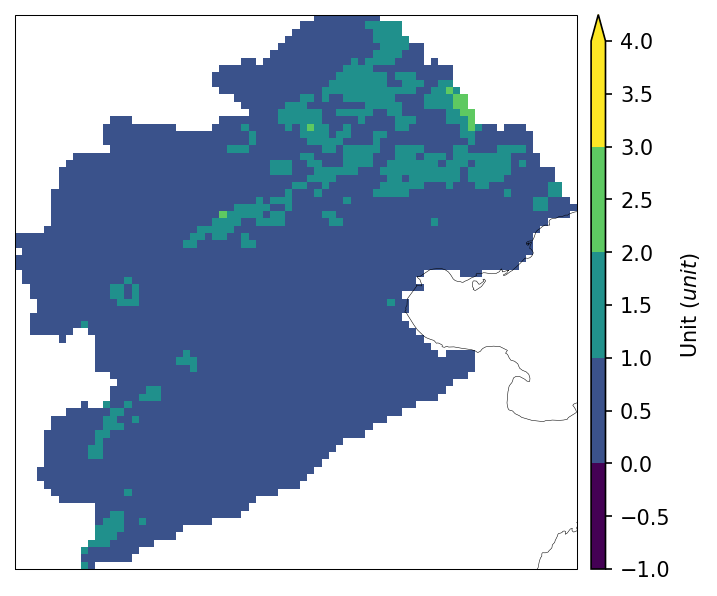

In [124]:
b = GlobalMap()
b.baseMap()
# b.ax.plot([114,20],[40, 20], transform=ccrs.PlateCarree())
# b.ax.get_extent(ccrs.PlateCarree())
b.stackImage(data[0], lat, lon)